### Question: does `model` returns `[0 prob, 1 prob]` before softmax?

In [25]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    AutoConfig,
    TextClassificationPipeline,
)
from engine.data import prepare_data_for_fine_tuning, read_data
from engine.xai import FeatureAblationText
import pandas as pd
from engine.ner_detector import text_preprocess

In [26]:
MODEL_ID = "roberta-base"
MODEL_PATH = "output/checkpoint-2025/model.safetensors"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

In [27]:
test = pd.read_csv("data/coaid/test.csv")
test['text'] = text_preprocess(test['text'].to_list())
print(test)
test_dataset = prepare_data_for_fine_tuning(test, tokenizer)

                                                   text  label
0                  Eddie Van Halen Dies of Cancer at 65      0
1     Have the Public Health Restrictions Gone Too F...      0
2     My experience battling COVID-19 - Medical News...      0
3     U.S. Government to Increase PPE Shipments to N...      0
4     Frequently Asked Questions about Hand Hygiene ...      0
...                                                 ...    ...
1087  How to Enjoy the Fourth of July Weekend Amid t...      0
1088         Wearing a Mask Doesn't Cause CO2 Poisoning      0
1089  Brain Affected in 1 in 3 Cases of Severe COVID-19      0
1090      CDC Reverses Guidance on Asymptomatic Testing      0
1091  Guidance for Child Care Programs that Remain Open      0

[1092 rows x 2 columns]


Map: 100%|██████████| 1092/1092 [00:00<00:00, 2985.85 examples/s]


In [28]:
import torch
def get_device():
    if torch.cuda.is_available():
        print("CUDA is available. Using GPU.")
        return "cuda"
    else:
        print("CUDA not available. Using CPU.")
        return "cpu"

In [29]:
config = AutoConfig.from_pretrained(MODEL_ID)
device = get_device()
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_PATH, config=config
)
model.eval()
pipeline = TextClassificationPipeline(
    model=model, tokenizer=tokenizer, top_k=2, device=device
)

CUDA not available. Using CPU.


In [30]:
%%capture
if(device == "cuda"):
    model.cuda()
else:
    model.cpu()

In [31]:
obs = test["text"].tolist()[247]
if(device == "cuda"):
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cuda()
else:
    obs_pt = pipeline.tokenizer(obs, return_tensors="pt")['input_ids'].cpu()

print(obs)
print(obs_pt)


Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries
tensor([[    0, 47948, 31466,    13, 39046,     9,  6247, 43814,    12,  1646,
          2573, 12663, 18541, 34131,    13,  9978,    12, 47279, 17658,     2]])


In [32]:
test["text"].tolist()[247]

'Framework for Implementation of COVID-19 Community Mitigation Measures for Lower-Resource Countries'

In [33]:
def forward(obs):
    return model(obs).logits

In [34]:

attr = FeatureAblationText(forward)
print(attr)
exp = attr.get_attributions([obs_pt])
exp

tensor([[[ 0.0000,  0.0538,  0.4446,  0.1849, -0.2241,  0.1099, -0.1032,
          -0.1553,  0.5039,  0.4015, -0.0625,  0.5543,  0.1677,  0.3854,
          -0.0915,  0.4746,  0.0211, -0.1978,  0.5711,  0.5254],
         [ 0.0000, -0.0586, -0.5037, -0.2044,  0.2370, -0.1204,  0.1106,
           0.1653, -0.5746, -0.4532,  0.0671, -0.6374, -0.1850, -0.4345,
           0.0980, -0.5393, -0.0229,  0.2097, -0.6518, -0.6015]]])

In [35]:
tokens = pipeline.tokenizer.convert_ids_to_tokens(obs_pt[0])
print(tokens)

['<s>', 'Fram', 'ework', 'Ġfor', 'ĠImplementation', 'Ġof', 'ĠCO', 'VID', '-', '19', 'ĠCommunity', 'ĠMit', 'igation', 'ĠMeasures', 'Ġfor', 'ĠLower', '-', 'Resource', 'ĠCountries', '</s>']


In [36]:
import spacy

NER = spacy.load("en_core_web_sm")

doc = NER(obs)

print("Entities in the text:")
for ent in doc.ents:
    print(f"{ent.text} ({ent.label_}) - {spacy.explain(ent.label_)}")

Entities in the text:
Lower-Resource Countries (ORG) - Companies, agencies, institutions, etc.


In [37]:
print("\nTokens and Their NER Information: \n")

for token in doc:
    if token.ent_type_:
        print(f"Token: {token.text}, Entity Type: {token.ent_type_} ({spacy.explain(token.ent_type_)})")
    else:
        print(f"Token: {token.text}, Not part of any entity.")


Tokens and Their NER Information: 

Token: Framework, Not part of any entity.
Token: for, Not part of any entity.
Token: Implementation, Not part of any entity.
Token: of, Not part of any entity.
Token: COVID-19, Not part of any entity.
Token: Community, Not part of any entity.
Token: Mitigation, Not part of any entity.
Token: Measures, Not part of any entity.
Token: for, Not part of any entity.
Token: Lower, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: -, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Resource, Entity Type: ORG (Companies, agencies, institutions, etc.)
Token: Countries, Entity Type: ORG (Companies, agencies, institutions, etc.)


In [38]:
print(len(tokens))

tokens_clear = [s.replace("Ġ", "") for s in tokens]
tokens_clear = tokens_clear[1:len(tokens_clear)-1]
print(tokens_clear)

print(exp)
print(len(exp))

20
['Fram', 'ework', 'for', 'Implementation', 'of', 'CO', 'VID', '-', '19', 'Community', 'Mit', 'igation', 'Measures', 'for', 'Lower', '-', 'Resource', 'Countries']
tensor([[[ 0.0000,  0.0538,  0.4446,  0.1849, -0.2241,  0.1099, -0.1032,
          -0.1553,  0.5039,  0.4015, -0.0625,  0.5543,  0.1677,  0.3854,
          -0.0915,  0.4746,  0.0211, -0.1978,  0.5711,  0.5254],
         [ 0.0000, -0.0586, -0.5037, -0.2044,  0.2370, -0.1204,  0.1106,
           0.1653, -0.5746, -0.4532,  0.0671, -0.6374, -0.1850, -0.4345,
           0.0980, -0.5393, -0.0229,  0.2097, -0.6518, -0.6015]]])
1


In [39]:
from engine.tokens_aggregate import TokenAggregate

In [40]:
aggregate_list = TokenAggregate.generate_aggregate_list(doc,exp[0],tokens_clear,tokens)

In [41]:
from engine.xai import FeatureAblation
from engine.tokens_aggregate import TokenAggregate
from engine.ner_detector import tokenize_evaluate_and_detect_NERs,generate_aggregates

all_aggregate = generate_aggregates(pipeline,[test["text"].tolist()[16]])

1it [00:00,  2.38it/s]


In [42]:
print(all_aggregate)

[[<engine.tokens_aggregate.TokenAggregate object at 0x000001CFAEFC6480>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9D577A40>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CFAB63B650>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E409A30>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E40BF80>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E40BB00>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E40BCE0>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E40A810>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E40A390>, <engine.tokens_aggregate.TokenAggregate object at 0x000001CF9E4099D0>]]


In [43]:
for doc_aggreagtes in all_aggregate:
    for aggregate in doc_aggreagtes:
        # if(len(aggregate.spacy_token)>1):
        print(aggregate)

Is spacy NER: ['']
spacy token: ['Why']
Our model clean: ['Why']
Our model dirty: ['Why']
model exp: [0.28311753273010254]

Is spacy NER: ['']
spacy token: ['are']
Our model clean: ['are']
Our model dirty: ['Ġare']
model exp: [0.2860696315765381]

Is spacy NER: ['']
spacy token: ['infections']
Our model clean: ['infections']
Our model dirty: ['Ġinfections']
model exp: [0.45081424713134766]

Is spacy NER: ['']
spacy token: ['from']
Our model clean: ['from']
Our model dirty: ['Ġfrom']
model exp: [-0.1003725528717041]

Is spacy NER: ['']
spacy token: ['animals']
Our model clean: ['animals']
Our model dirty: ['Ġanimals']
model exp: [-0.008495330810546875]

Is spacy NER: ['']
spacy token: ['so']
Our model clean: ['so']
Our model dirty: ['Ġso']
model exp: [0.0025870800018310547]

Is spacy NER: ['']
spacy token: ['dangerous']
Our model clean: ['dangerous']
Our model dirty: ['Ġdangerous']
model exp: [-0.3445112705230713]

Is spacy NER: ['']
spacy token: ['to']
Our model clean: ['to']
Our model

In [44]:
test = pd.read_csv("data/isot/test.csv")

In [45]:
token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist()[253:254],ners_to_calculate_ablation=['PERSON'])

1it [00:00, ?it/s]
100%|██████████| 1/1 [00:00<?, ?it/s]
1it [00:00, 13.40it/s]
100%|██████████| 1/1 [00:00<?, ?it/s]


795it [00:00, 264766.69it/s]
100%|██████████| 795/795 [00:00<00:00, 58377.63it/s]
795it [01:34,  8.38it/s]
100%|██████████| 795/795 [00:00<00:00, 37669.56it/s]


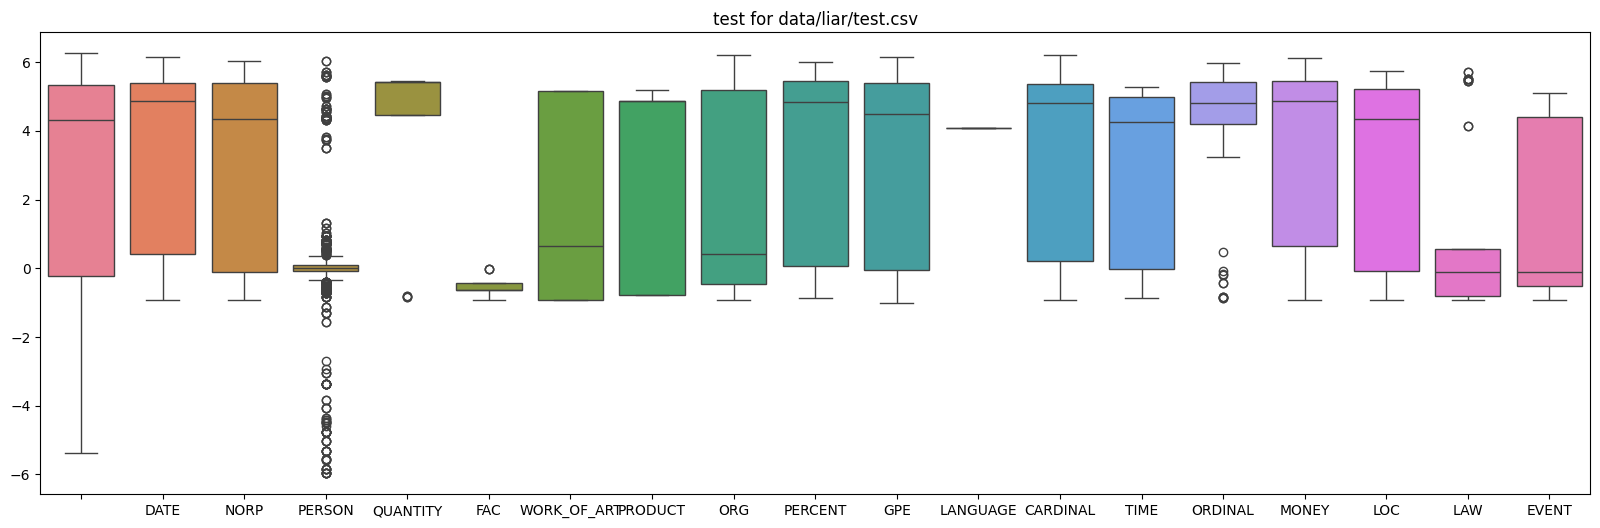

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_names = ["liar"]
results_for_data_filtered = {}
for data_name in data_names:
    file = f"data/{data_name}/test.csv"
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist(),ners_to_calculate_ablation=['PERSON'])
    results_for_data_filtered[data_name] = token_exp_NERs
    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(exp)


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"test for {file}")
    plt.show()

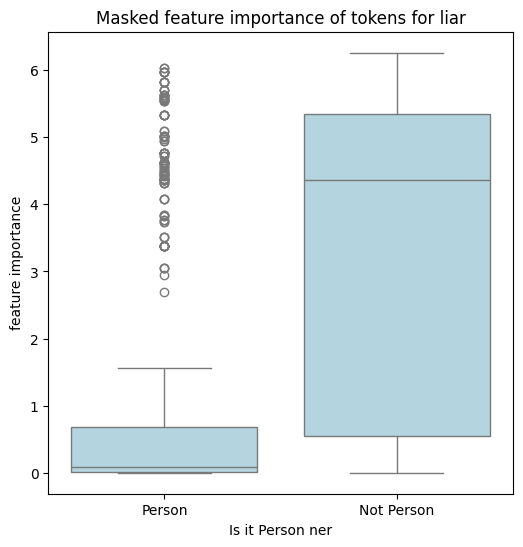

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_filtered[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {"Person":[],"Not Person":[]}


    for token, exp, ner in token_exp_NERs:
        if(ner == "PERSON"):
            exps["Person"].append(abs(exp))
        else:
            exps["Not Person"].append(abs(exp))

    plt.figure(figsize=(6, 6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Is it Person ner")
    sns.boxplot(data=exps, palette=box_colors)  # Pass the color list
    plt.title(f"Masked feature importance of tokens for {data_name}")
    plt.savefig(f"graph_output\\feature_importance_graphs\\Masked feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()


795it [14:25,  1.09s/it]
100%|██████████| 795/795 [00:00<00:00, 47949.72it/s]


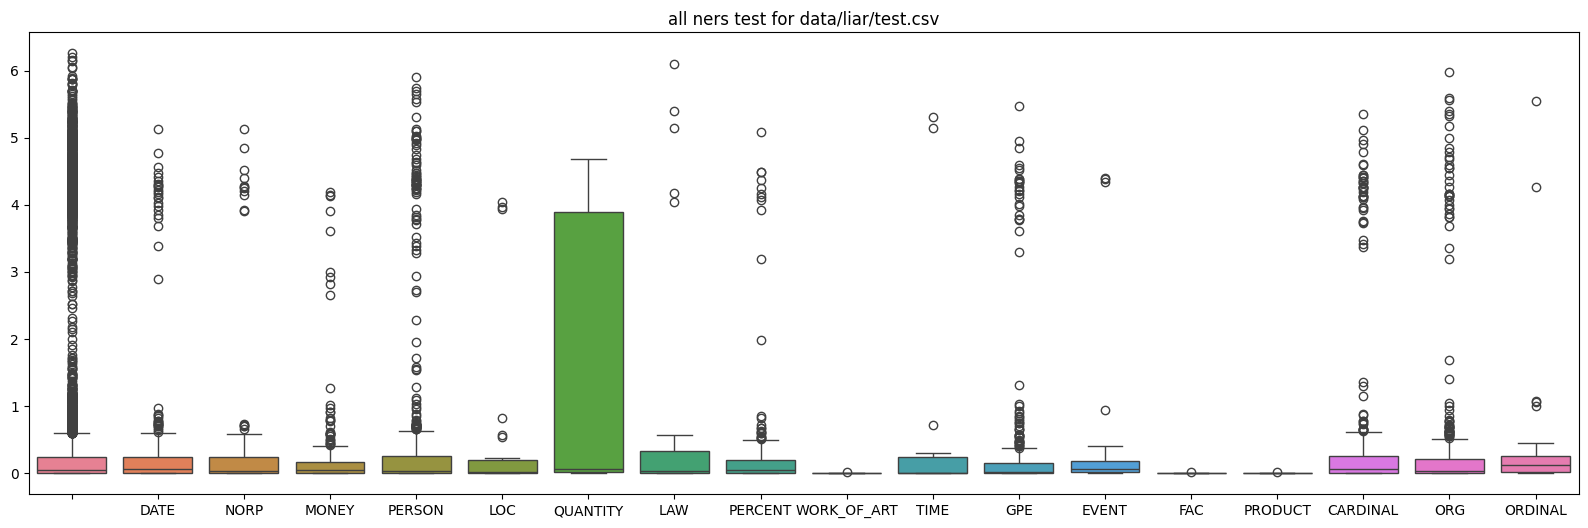

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_names = ["liar"]
results_for_data_all_ners= {}
for data_name in data_names:
    file = f"data/{data_name}/test.csv"
    test = pd.read_csv(file)
    token_exp_NERs = tokenize_evaluate_and_detect_NERs(pipeline,test["text"].tolist(),spacy_model =  "en_core_web_lg",)
    results_for_data_all_ners[data_name] = token_exp_NERs
    all_ner_types = set()

    for _,_,ner in token_exp_NERs:
            all_ner_types.add(ner)
            
    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(abs(exp))


    plt.figure(figsize=(20,6))
    sns.boxplot(exps)
    plt.title(f"all ners test for {file}")
    plt.show()

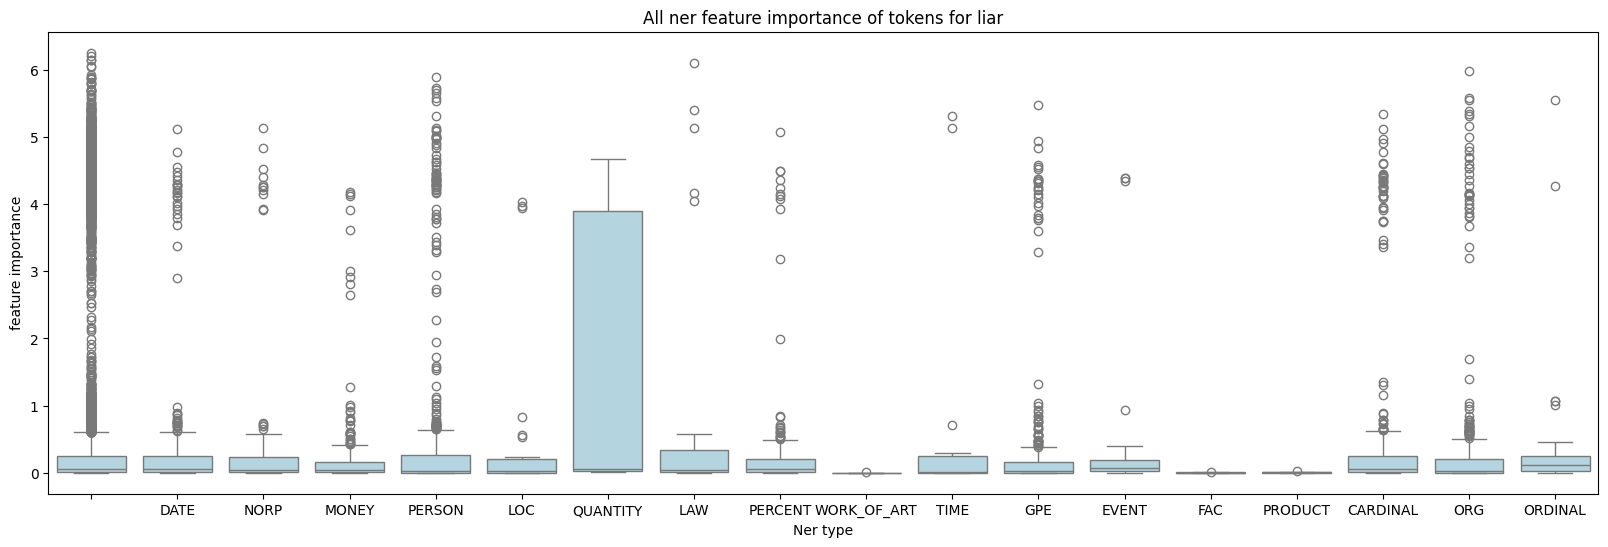

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_all_ners[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {}
    for ner_type in all_ner_types:
        exps[ner_type] = []



    for token,exp,ner in token_exp_NERs:
        exps[ner].append(abs(exp))

    plt.figure(figsize=(20,6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Ner type")
    sns.boxplot(data=exps, palette=box_colors)  # Pass the color list
    plt.title(f"All ner feature importance of tokens for {data_name}")
    plt.savefig(f"graph_output\\feature_importance_graphs\\All ner feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()


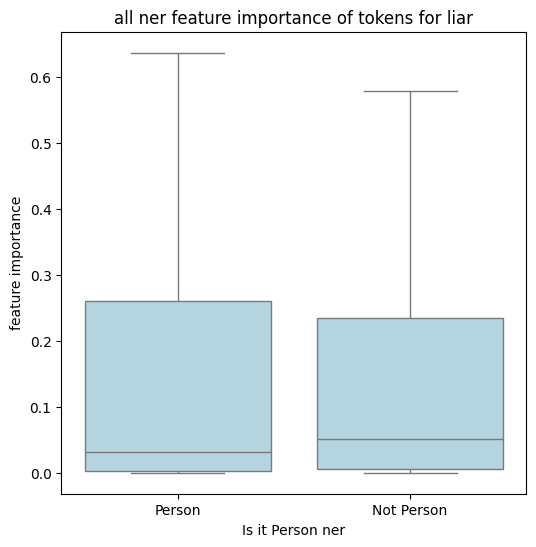

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

for data_name in data_names:
    token_exp_NERs = results_for_data_all_ners[data_name]
    all_ner_types = set()

    for _, _, ner in token_exp_NERs:
        all_ner_types.add(ner)

    exps = {"Person":[],"Not Person":[]}


    for token, exp, ner in token_exp_NERs:
        if(ner == "PERSON"):
            exps["Person"].append(abs(exp))
        else:
            exps["Not Person"].append(abs(exp))

    plt.figure(figsize=(6, 6))
    
    # Assign the same color to all boxes
    box_colors = ["lightblue"] * len(exps)  # A list of the same color for all boxes
    plt.ylabel("feature importance")
    plt.xlabel("Is it Person ner")
    sns.boxplot(data=exps, palette=box_colors,showfliers=False)  # Pass the color list
    plt.title(f"all ner feature importance of tokens for {data_name}")
    plt.savefig(f"graph_output\\feature_importance_graphs\\Masked feature importance of tokens for {data_name}")  # Assuming you meant `data_name` instead of `file`
    plt.show()